# Titanic Survival Prediction Notebook
## Samir Mohammed
### Task 1

# Importing Dataset

In [41]:
import os
notebook_dir = "C:/Users/sm94c/Documents/Data Science Projects/Titanic Dataset"
# Change the current working directory
os.chdir(notebook_dir)

In [42]:
import pandas as pd

df = pd.read_csv("train.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Examining Dataset

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [45]:
df.isna().sum()
#there are 177 null values in age, 1 in fare and 687 in Cabin. We won't use cabin because of the number of missing variables

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

We can use a scikitlearn pipeline to clean the data and classify it, so we will skip imputing these values in at this stage.

# Creating Machine Learning Model

We will use an XGBoost pipeline to classify the survivors. 

In [108]:
X = df[['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']] #collecting all the predictor variables

y = df['Survived'] #assigning y value as the output to train on


In [109]:
X

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...
886,2,male,27.0,0,0,13.0000,S
887,1,female,19.0,0,0,30.0000,S
888,3,female,NaN,1,2,23.4500,S
889,1,male,26.0,0,0,30.0000,C


In [48]:
y

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

In [49]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Creating Processing and Training Pipeline

In [116]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from xgboost import XGBClassifier

categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(exclude=['object']).columns

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Changed imputation strategy to median
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OrdinalEncoder())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

model = XGBClassifier(random_state=42)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', model)
])

# Assuming X_train and y_train are defined
pipeline.fit(X_train, y_train)

# Evaluate the pipeline on a separate validation or test set
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.7877094972067039


In [117]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(pipeline, X, y, cv=5)  # Perform 5-fold cross-validation

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", cv_scores.mean())

Cross-Validation Scores: [0.7877095  0.81460674 0.85393258 0.7752809  0.83707865]
Mean Accuracy: 0.8137216747222397


## Using Optuna Hyperparameter Optimization
- Without optimization accuracy:  0.8137216747222397

In [128]:
import optuna
def objective_xgb(trial):
    params = {
        "eval_metric": "mlogloss",
        "objective": "multi:softmax",
        "booster": trial.suggest_categorical("booster", ["gbtree"]),
        "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 1.0, log=True),
        "gamma": trial.suggest_float("gamma", 1e-9, 0.5),
        "subsample": trial.suggest_float("subsample", 0.3, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 1.0),
        "max_depth": trial.suggest_int("max_depth", 5, 24),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 7),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-9, 100.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-9, 100.0, log=True),
        "num_class": 2,
    }
    
    # Create the XGBoost classifier with the current set of hyperparameters
    model_xgb = XGBClassifier(**params)

    # Construct the full pipeline with the classifier
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model_xgb)
    ])

    # Fit the pipeline on the training data
    pipeline.fit(X_train, y_train)

    # Predict and calculate accuracy on the validation set
    y_pred_c = pipeline.predict(X_test)

    return accuracy_score(y_test, y_pred_c)


study_xgboost = optuna.create_study(
    study_name="Study_XGB_Obesity", direction="maximize"
)
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_xgboost.optimize(objective_xgb, n_trials=50, show_progress_bar=True)

# Get the best hyperparameters
best_params_xgb = study_xgboost.best_params
print("Best Hyperparameters:", best_params_xgb)

  0%|          | 0/50 [00:00<?, ?it/s]

Best Hyperparameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'n_estimators': 984, 'learning_rate': 0.01535501156195284, 'gamma': 0.07313908687818282, 'subsample': 0.5533059102555777, 'colsample_bytree': 0.8016238277705745, 'max_depth': 10, 'min_child_weight': 5, 'reg_lambda': 1.3955877986639501e-08, 'reg_alpha': 7.171536085576677e-06}


In [118]:
new_params = {'booster': 'gbtree', # 82.61
              'grow_policy': 'lossguide',
              'n_estimators': 895,
              'learning_rate': 0.017054333628010277,
              'gamma': 0.44310580975236263,
              'subsample': 0.6381551724807623,
              'colsample_bytree': 0.807983630924162,
              'max_depth': 19,
              'min_child_weight': 7,
              'reg_lambda': 0.00033308333616621414,
              'reg_alpha': 1.5085870691552168e-07
             }


xgb = XGBClassifier(random_state=42, **new_params)

# Update the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', xgb)
])


In [119]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(pipeline, X, y, cv=5)  # Perform 5-fold cross-validation

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", cv_scores.mean())

Cross-Validation Scores: [0.78212291 0.83707865 0.86516854 0.82022472 0.81460674]
Mean Accuracy: 0.8238403113426653


Improved average accuracy to 0.8260812252840374

In [120]:
from sklearn.metrics import accuracy_score

pipeline.fit(X_train,y_train)
y_pred_test = pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_test)
print("Accuracy on test set:", accuracy)

Accuracy on test set: 0.8379888268156425


In [124]:

# Extracting feature names after preprocessing
# For numerical features, get the names after transformation
numerical_feature_names = pipeline.named_steps['preprocessor']\
    .named_transformers_['num'].named_steps['scaler']\
    .get_feature_names_out(input_features=numerical_cols)

# For categorical features, get the names after one-hot encoding
categorical_feature_names = pipeline.named_steps['preprocessor']\
    .named_transformers_['cat'].named_steps['onehot']\
    .get_feature_names_out(input_features=categorical_cols)

# Concatenate numerical and categorical feature names
feature_names = np.concatenate([numerical_feature_names, categorical_feature_names])

# Accessing the XGBoost model from the pipeline
xgb_model = pipeline.named_steps['classifier']

# Extracting feature importance
feature_importance = xgb_model.feature_importances_

# Pairing feature names with their importance scores
features_importance_dict = dict(zip(feature_names, feature_importance))

# Sorting features by importance (descending order)
sorted_features_importance = dict(sorted(features_importance_dict.items(), key=lambda x: x[1], reverse=True))

# Print feature names and their importance scores
for feature, importance in sorted_features_importance.items():
    print(f"{feature}: {importance}")

Sex: 0.47941893339157104
Pclass: 0.1676132082939148
Parch: 0.07597095519304276
Embarked: 0.0749925747513771
SibSp: 0.06809727847576141
Age: 0.06735020130872726
Fare: 0.06655685603618622


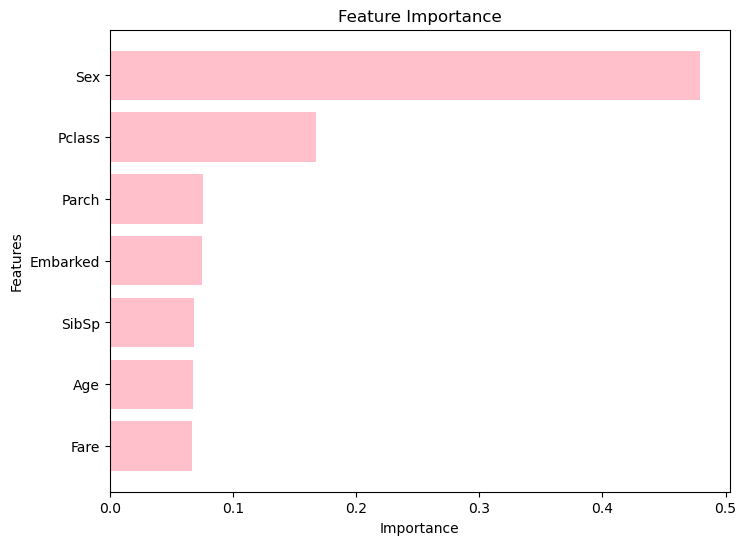

In [127]:
features = list(sorted_features_importance.keys())
importance = list(sorted_features_importance.values())

# Plotting the bar plot
plt.figure(figsize=(8, 6))
plt.barh(features, importance, color='pink')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()